In [2]:
from Bio import AlignIO
from Bio.Align import AlignInfo 
from multiprocessing import Pool
from Bio import motifs
from Bio.Seq import Seq
import pickle
import numpy as np
import glob
import os 
import pandas as pd
from Bio import SeqIO
import csv
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [3]:
char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

def getPosition_Probability_Matrix(_matrix):
    num_columns = len(_matrix[0])
    keys = _matrix.keys()
   # print(num_columns)
    d = {}

    for i in range(num_columns):
        #print("postion:"+str(i))
        sub_dict = {}
        for char in keys:
            if _matrix[char][i] != 0 :
                sub_dict[char] =  round(_matrix[char][i],4)
        
        d[i]=(sub_dict)
        #cleaned = set(n for n in value if n != 0) 
        #d[key] = cleaned
    
    #cleaned = [tuple(n for n in sublist if n != 0) for sublist in _matrix]
    return d

def calculateProtien_PositionSpecificScoringMatrix(sequence, predefine_matrix):
    scores = 0
    score= 0
    raw_score = 0
    max_score = pssm.max
    min_score = pssm.min
    for i in range( len(sequence) ):
        score =predefine_matrix[sequence[i]][i]
        scores += score
        raw_score += score
        rel_score = (score - min_score) / (max_score - min_score)
        print("Position %d: score = %5.4f, rel. score = %5.4f" % (
            i, score, rel_score))
    print("Max_raw_score:"+ str(max_score) ) 
    print("Min_raw_score:"+ str(min_score) ) 
    print("raw_score:"+ str(raw_score) )   
    rel_score = (scores - min_score) / (max_score - min_score)
    return rel_score

def convert_protein_pwm(sequence):
    m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  
    index_pattern = [char for char in m.consensus]
    pwm = m.counts.normalize(pseudocounts=0.05)
    pwm_df = pd.DataFrame.from_dict(pwm)
    pwm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    # Sum value of column A...Y 
    # For example. sum value of 
    for  char in char_code_list: # column
        for index, row in pwm_df.iterrows():
            result_df.loc[index, char] += row[char]
    _flat = result_df.values.flatten()

    return _flat, pwm_df, result_df

from pathlib import Path
def scale_by(x_ar):
    # sigmod function 
    return 1 / (1 + np.exp(x_ar * -1)) 

def NormalizeData(x,_min,_max):
    return  (x - _min) / (_max - _min) 

def NormalizeData_V1(x):
    return  (x - x.min()) / (x.max() - x.min()) 



def convert_to20X20_(pssm , index_pattern):
    """
    
    pssm: dcit
        get pssm as dict 
    """
    pssm_df = pd.DataFrame.from_dict(pssm)
    pssm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    for  char in char_code_list: # column
        for index, row in pssm_df.iterrows():
            result_df.loc[index, char] += round(row[char],2)
    return result_df

def get_pssm(m):
    pwm = m.counts.normalize(pseudocounts=0.05)
    pssm = pwm.log_odds()
    return pssm

def create_image(df,file):
    plt.axis("off")
    plt.imshow(df)
    plt.savefig(file, bbox_inches='tight', pad_inches=0)

In [4]:
from os import getpid
from functools import partial

num_partitions = 24 #number of partitions to split dataframe 22
num_cores = 24 #number of cores on your machine 22

def convert_pssm(df):
    process_id =str(getpid())
    path = "/mnt/vdb/thesis/trainingset2/set1/pssm/AMP"
    pro_plk = os.path.join(path, "chunk"+process_id+".pkl")
    if not os.path.exists(path):
        os.makedirs(path)
    
    print(process_id+" Start")

    char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

    ready_df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
    for index, seq_record in df.iterrows():
        #print(seq_record)
        m = motifs.create([ seq_record["Sequence"] ] , alphabet="ACDEFGHIKLMNPQRSTVWY")  
        index_pattern = [char for char in m.consensus]
        
        name = seq_record["ID"].replace('/', '_')
        name = name.replace('|', '_')
        if len(name) > 25:
            # Accessing out of range element causes error
            name = name[0:25]
            
        file_name = os.path.join('/mnt/vdb/thesis/trainingset2/set1/pssm/images/AMP', name+'.png')
        pssm = get_pssm(m)
        result_df = convert_to20X20_(pssm , index_pattern)
        result_df = scale_by(result_df/len(m.consensus))
        create_image(result_df,file_name) 

        _flat = result_df.values.flatten()
 
        ready_df = ready_df.append({'ID': seq_record["ID"], 'Sequence': seq_record["Sequence"],
                                   'reps': _flat, 'length': seq_record["length"]}, ignore_index=True) 
    print(process_id+" Finish")
    output = open(pro_plk, 'wb')
    pickle.dump(ready_df, output)
    output.close()


def convert_pssm_cluster(list_ndarray):
    process_id =str(getpid())
    path = "/mnt/vdb/thesis/trainingset2/set1/pssm/AMP"
    pro_plk = os.path.join(path, "chunk"+process_id+".pkl")
    if not os.path.exists(path):
        os.makedirs(path)
    print(process_id+" Start")
    char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

    ready_df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
    for file in list_ndarray:
        count = 0 
        ## print(file)
        identifiers = []
        lengths = []
        sequence = []
        _flat = []
        ## should be MSA (e.g.,5 seqs per cluster) then create PSSM, not create from each seq 
        for seq_record in SeqIO.parse(file, 'fasta'):
             ###if count == 5:
            ###    break
            ##identifiers.append(seq_record.id)
            sequence.append(str(seq_record.seq))
            ##lengths.append(len(seq_record.seq))
            
        m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  

        index_pattern = [char for char in m.consensus]
        file_name =  Path(file).stem 
        
        file_ = '/mnt/vdb/thesis/trainingset2/set1/pssm/images/AMP/'+file_name+'.png'
        
        pssm = get_pssm(m)
        result_df = convert_to20X20_(pssm , index_pattern)
        result_df = scale_by(result_df/len(m.consensus))
        create_image(result_df,file_) 

        _flat = result_df.values.flatten()
        print(str(m.consensus))
        ready_df = ready_df.append({'ID': file_name, 'Sequence': str(m.consensus),
                                   'reps': _flat, 'length': len(m.consensus)}, ignore_index=True) 
    
    
    print(process_id+" Finish")
    output = open(pro_plk, 'wb')
    pickle.dump(ready_df, output)
    output.close()

def parallelize_dataframe(df, func):
    _tmp_df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    pool.map(func, _tmp_df_split)

    pool.close()
    pool.join()
    
def get_df(fastas):
    with open(fastas) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        seqs = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            # Remove leading and trailing characters from a string
            seqs.append(str(seq_record.seq.strip('*')))
            lengths.append(len(seq_record.seq))
    # dictionary of lists  
    dict = {'ID': identifiers, 'Sequence': seqs, 'length': lengths}  
    df = pd.DataFrame(dict) 
    return df

def mergeDF(path,to_dir,file_name):
    appended_data = []
    for infile in glob.glob(path):
        #print(infile)
        data = pd.read_pickle(infile)
        # store DataFrame in list
        appended_data.append(data)
        
    result_path=to_dir+"/"+file_name
    print("Save:",result_path)
    appended_data = pd.concat(appended_data, ignore_index=True)
    appended_data.to_pickle(result_path)
    return appended_data

In [11]:
def convert_pssm_cluster_DF(df):
    process_id =str(getpid())
    
    path = "/mnt/vdb/thesis/trainingset2/set9/pssm/AMP"
    pro_plk = os.path.join(path, "chunk"+process_id+".pkl")
    if not os.path.exists(path):
        os.makedirs(path)
    iamge_path =  '/mnt/vdb/thesis/trainingset2/set9/pssm/images/AMP/'   
    if not os.path.exists(iamge_path):
        os.makedirs(iamge_path)    
        
    print(process_id+" Start")
    char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 
    ready_df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
    cluster = df["Cluster"].unique().tolist()

    for  row in cluster:
        count = 0 
        ## print(file)
        sequence = []
        _flat = []
        ## should be MSA (e.g.,5 seqs per cluster) then create PSSM, not create from each seq 
        
        ### Search by cluster 
        sequence = df[df["Cluster"] == row].Sequence.to_list() 
        
        m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  

        index_pattern = [char for char in m.consensus]
        #file_name =  Path(file).stem 
        file_name = row
        file_ = iamge_path + file_name+'.png'
        
        pssm = get_pssm(m)
        result_df = convert_to20X20_(pssm , index_pattern)
        result_df = scale_by(result_df/len(m.consensus))
        create_image(result_df,file_) 

        _flat = result_df.values.flatten()
        # print(str(m.consensus))
        ready_df = ready_df.append({'ID': file_name, 'Sequence': str(m.consensus),
                                   'reps': _flat, 'length': len(m.consensus)}, ignore_index=True) 
        
    print(process_id+" Finish")
    output = open(pro_plk, 'wb')
    pickle.dump(ready_df, output)
    output.close()

# Solution 1 

## AMP /(multicore )

In [21]:
mylist = [f for f in glob.glob("/mnt/vdb/thesis/pwm/AMP/tmp_cluster/*_800.fasta")]
_tmp_df_split = np.array_split(mylist, num_partitions)
len(_tmp_df_split)

24

In [5]:
mylist = [f for f in glob.glob("/mnt/vdb/thesis/pwm/AMP/tmp_cluster/*.fasta")]
parallelize_dataframe(mylist, convert_pssm_cluster)

30137 Start30140 Start30139 Start30142 Start30138 Start
30141 Start30143 Start
30144 Start

30145 Start

30146 Start30152 Start30151 Start
30148 Start30154 Start
30149 Start
30155 Start


30156 Start
30153 Start30160 Start
30157 Start
30159 Start30158 Start

30147 Start





30150 Start
30140 Finish
30152 Finish
30155 Finish
30145 Finish
30144 Finish
30138 Finish
30159 Finish
30148 Finish
30153 Finish
30139 Finish
30156 Finish
30160 Finish
30146 Finish
30150 Finish
30142 Finish
30143 Finish
30151 Finish
30149 Finish
30154 Finish
30137 Finish
30158 Finish
30141 Finish
30147 Finish
30157 Finish


In [54]:
path = "/mnt/vdb/thesis/pwm/AMP/"
result_df = mergeDF(path+"/*.pkl",path,"AMP_C08_S06.pssm.plk")

Save: /mnt/vdb/thesis/pwm/AMP//AMP_C08_S06.pssm.plk


<AxesSubplot:>

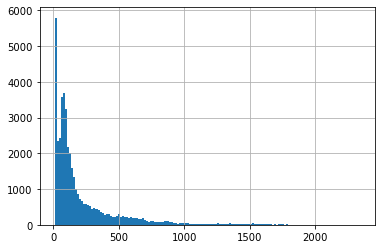

In [55]:
result_df.length.hist(bins=150)

In [62]:
np.round(result_df.reps[0], 4)

array([0.5375, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964,
       0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964,
       0.4964, 0.4964, 0.4964, 0.4964, 0.4994, 0.5066, 0.4994, 0.4994,
       0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994,
       0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994,
       0.4979, 0.4979, 0.5221, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979,
       0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979,
       0.4979, 0.4979, 0.4979, 0.4979, 0.4977, 0.4977, 0.4977, 0.5243,
       0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977,
       0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977,
       0.4981, 0.4981, 0.4981, 0.4981, 0.5199, 0.4981, 0.4981, 0.4981,
       0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981,
       0.4981, 0.4981, 0.4981, 0.4981, 0.4972, 0.4972, 0.4972, 0.4972,
       0.4972, 0.5287, 0.4972, 0.4972, 0.4972, 0.4972, 0.4972, 0.4972,
      

## solution 2 padding

--> https://www.nature.com/articles/s41598-020-71450-8

# Trainingset2

## SEt1

In [31]:
df=pd.read_pickle("../datasets/thesis/trainingset2/set1/final_balance_set_1.pkl")
AMP_df = df[df["class"] == 0]
nonAMP_df = df[df["class"] == 1]

In [ ]:
parallelize_dataframe(AMP_df, convert_pssm)

11798 Start
11800 Start11799 Start11802 Start11801 Start

11803 Start

11804 Start
11806 Start11805 Start

11807 Start
11808 Start11809 Start

11810 Start

11811 Start11812 Start11813 Start

11814 Start
11815 Start

11816 Start
11818 Start11817 Start
11819 Start11821 Start11820 Start





In [33]:
path = "/mnt/vdb/thesis/trainingset2/set1/pssm/AMP"
result_df = mergeDF(path+"/*.pkl",path,"AMP.pssm.plk")
result_df

Save: /mnt/vdb/thesis/trainingset2/set1/pssm/AMP/AMP.pssm.plk


,ID,Sequence,reps,length
0,EN4254515|E|E0IBV2|bacteriocin,MLTLDQVKNKSAARLIGLHPVVQQATVRLIELAYQAGVPIVITQGL...,"[0.6267900692021158, 0.46183906211858095, 0.46...",255
1,EN85237480|E|E8T1U8|bacteriocin,MELVELLFRAEKRLSGLHPLVADKARALIRKAYEEGIYIIITQGFR...,"[0.5648253763537499, 0.4807787077893918, 0.480...",156
2,EN47673028|E|C6D2R3|bacteriocin,MPEPLARQDTTVGRIGQPYVRPEQKQKRSRVMTSLVLVAIIVMGWR...,"[0.5714648444065747, 0.47878632743754573, 0.47...",212
3,EN33112693|E|G2RV22|bacteriocin,MSDLSLDKLLQKAENKLQNVHEIVQEKSYELIRQAYKESIFVVITE...,"[0.5366226083209371, 0.48917917900136787, 0.48...",231
4,EN25767662|E|D5DQ70|bacteriocin,MSGLSLDKLLKKAENKLQNVHEIVQEKSYELIRQAYKESIFVVITE...,"[0.5439125458547542, 0.48701590678793916, 0.48...",231
...,...,...,...,...
49981,DRAMP26632|specific_amps,YYLNCTPFMLQSTQIMKGTY,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",20
49982,DRAMP24064|specific_amps,YYLSPSLTPVR,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",11
49983,DRAMP24206|specific_amps,YYNRFGGRCSSL,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",12
49984,DRAMP23686|specific_amps,YYTGPTTHNWHFALESDSRD,"[0.5422738369387539, 0.4875026035157896, 0.487...",20


## SET 3

In [27]:
df=pd.read_pickle("../datasets/thesis/trainingset2/set3/final_balance_set_3.pkl")
AMP_df = df[df["class"] == 0]
parallelize_dataframe(AMP_df, convert_pssm)
path = "/mnt/vdb/thesis/trainingset2/set3/pssm/AMP"
result_df = mergeDF(path+"/*.pkl",path,"AMP.pssm.plk")
result_df

7774 Start7775 Start

7772 Start7776 Start7777 Start
7780 Start
7779 Start7781 Start7782 Start
7783 Start

7778 Start7784 Start
7773 Start7785 Start


7786 Start





7789 Start7795 Start7790 Start7787 Start7794 Start7793 Start7791 Start

7792 Start



7788 Start
7787 Finish
7793 Finish
7775 Finish
7794 Finish
7780 Finish
7795 Finish
7778 Finish
7789 Finish
7788 Finish
7782 Finish
7777 Finish
7784 Finish
7781 Finish
7783 Finish
7785 Finish
7786 Finish
7776 Finish
7790 Finish
7773 Finish
7779 Finish
7772 Finish
7792 Finish
7774 Finish
7791 Finish
Save: /mnt/vdb/thesis/trainingset2/set3/pssm/AMP/AMP.pssm.plk


,ID,Sequence,reps,length
0,"TPCK_ASPFU,Probable_decarboxylase_tpcK,1.-.-.-,",MGESSRKPSRYLCLTICGYRKPGMSEEDYRRYMTEVSAPMTKDLMV...,"[0.5357487570116085, 0.48943819105753, 0.48943...",142
1,"TRAC_HUMAN,T_cell_receptor_alpha_chain_constant,",IQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDK...,"[0.5422738369387539, 0.4875026035157896, 0.487...",140
2,"TRAP_PHUV,Transcriptional_activator_protein,TrAP,",MTGSKKTPSTSPSKKLSSPPEVKLRHRFAKRQIRRRRIDLACGCSI...,"[0.5367812632341595, 0.4891321467408431, 0.489...",138
3,"TSI3_PSEAE,Immune_protein_Tsi3,",MKTVALILASLALLACTAESGVDFDKTLTHPNGLVVERPVGFDARR...,"[0.6148122850510999, 0.4655718070254902, 0.465...",145
4,"TSLP_MOUSE,Thymic_stromal_lymphopoietin,",MVLLRSLFILQVLVRMGLTYNFSNCNFTSITKIYCNIIFHDLTGDL...,"[0.5302309383375392, 0.4910723774907236, 0.491...",140
...,...,...,...,...
2639,"IMM0_ECOLX,Colicin-E1_immunity_protein,",MSLRYYIKNILFGLYCTLIYIYLITKNSEEYYFLVTDKMLYAIVIS...,"[0.5448788923735801, 0.48672878156352406, 0.48...",113
2640,"IMM3_ECOLX,Colicin-E3_immunity_protein,",MGLKLDLTWFDKSTEDFKGEEYSKDFGDDGSVMESLGVPFKDNVNN...,"[0.5099692668422792, 0.49705885745254635, 0.49...",85
2641,"IMM5_ECOLX,Colicin-E5_immunity_protein,",MKLSPKAAIEVCNEAAKKGLWILGIDGGHWLNPGFRIDSSASWTYD...,"[0.5709929754752359, 0.47892815113723963, 0.47...",83
2642,"IMMD_ECOLX,Colicin-D_immunity_protein,",MNKMAMIDLAKLFLASKITAIEFSERICVERRRLYGVKDLSPNILN...,"[0.5773060477594137, 0.47702767892497366, 0.47...",87


## SET 9

In [12]:
_fasta = "/mnt/vdb/thesis/trainingset2/set9/final_AMP_set_9.clustres_all_seqs.fasta"
count_ = 0
with open(_fasta) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    clusters = []
    cluster_name= ""
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # begin create cluster
        if str(seq_record.seq) == "" :
            cluster_name = "cluster"+str(count_)
            count_ = count_ + 1

        identifiers.append(seq_record.id)
        sequence.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))
        clusters.append(cluster_name)
AMP_df = pd.DataFrame(list(zip(identifiers, sequence, clusters, lengths)), columns =['ID', 'Sequence','Cluster', 'length']) 
AMP_df.drop(AMP_df[AMP_df.Sequence == ""].index, inplace=True)
parallelize_dataframe(AMP_df, convert_pssm_cluster_DF)
path = "/mnt/vdb/thesis/trainingset2/set9/pssm/AMP"
result_df = mergeDF(path+"/*.pkl",path,"AMP.pssm.plk")
result_df

24455 Start
24456 Start
24457 Start
24458 Start
24459 Start
24460 Start24461 Start

24462 Start
24463 Start24464 Start
24465 Start
24466 Start

24467 Start
24468 Start
24469 Start24470 Start24471 Start


24472 Start24473 Start
24474 Start

24478 Start24477 Start24475 Start24476 Start



24478 Finish
24466 Finish
24468 Finish
24459 Finish
24472 Finish
24477 Finish
24475 Finish
24456 Finish
24469 Finish
24455 Finish
24461 Finish
24462 Finish
24476 Finish
24471 Finish
24460 Finish
24474 Finish
24463 Finish
24458 Finish
24473 Finish
24467 Finish
24464 Finish
24470 Finish
24457 Finish
24465 Finish
Save: /mnt/vdb/thesis/trainingset2/set9/pssm/AMP/AMP.pssm.plk


,ID,Sequence,reps,length
0,cluster25713,SDVARRFMRRQSRVIKGLV,"[0.544095668702679, 0.47370848260698156, 0.473...",19
1,cluster25714,RDVCRNFMRRYQSRVIQGLV,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",20
2,cluster25715,RDVSRRFMRRGRDVSRRFMRR,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",21
3,cluster25716,RDVSRRFMRRRDVSRRFMRR,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",20
4,cluster25717,RECRIGNGQCKNQCHENEIRIAYCIRPGTHCCLQ,"[0.5249058410464313, 0.4926475888339939, 0.492...",34
...,...,...,...,...
35387,cluster1454,EQEKREEENQEEDEENEAASEEKRGLMSSIGKALGGLIVNVLKPKTPAS,"[0.5687455095179431, 0.47960316233383543, 0.47...",49
35388,cluster1455,EEERAADDEDGDEEEEMKRGLFSIIKGAGKIAGKGLAKEAGKMGLD...,"[0.5952075530475947, 0.45078487089866653, 0.45...",56
35389,cluster1456,EQERDADEDENEQEAKVEDVKRAGYSRMIRRPPGFTPFRIAPASSV...,"[0.5844348515276352, 0.4748732549192566, 0.474...",169
35390,cluster1457,EQERDADEDENESRTVRVPPGFTPFRIAPASSLKRNADADETERRI...,"[0.6030608942265727, 0.4557577219221794, 0.455...",187
